In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import seaborn as sns
from tqdm import tqdm
import datetime
import calendar
from collections import defaultdict


def report_metrics(y_true, y_pred):
    '''
    Output metrics of predictions vs truth
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2


def month_str(time):
    '''
    Returns two strings representing the first and last day of time's month
    '''
    if time.month < 10:
        month_str = "0" + str(time.month)
    else:
        month_str = str(time.month)

    start_str = str(time.year) + "-" + month_str + "-01 00:14:00"
    last_day = calendar.monthrange(time.year, time.month)[1]
    end_str = str(time.year) + "-" + month_str + "-" + str(last_day) + " 23:59:00"
    return start_str, end_str


def year_str(time):
    '''
    Returns two strings representing the first and last day of time's year
    '''
    start_time = str(time.year) + "-01-01 00:14:00"
    end_time = str(time.year) + "-12-31 23:59:00"
    return start_time, end_time



class Normalised_Flow_Model:
    def __init__(self, train_report):
        self.time_range = pd.date_range("2019-03-19 00:14:00", "2022-04-08 23:59:00", freq="15min")
        # Don't include out of sync time values
        train_report_in_range = train_report[train_report.timestamp.isin(self.time_range)]
        self.predictions = train_report_in_range.groupby('timestamp')['total_volume_normalised'].median().to_frame().reset_index()
        self.true_mu = self.predictions.total_volume_normalised.sum() / len(self.time_range)
        self.empty_times = []
        
    def check_empties(self):
        for t in tqdm(self.time_range):
            if len( self.predictions[self.predictions.timestamp==t] ) <1:
                self.empty_times.append(t)
                
        print(f"{len(self.empty_times)} of {len(self.time_range)} time values are empty, {len(self.empty_times)/len(self.time_range) *100} %")
        
    def N(self,t):
        result = self.predictions[self.predictions.timestamp == t]
        if len(result) == 1:
            N_t = result.total_volume_normalised.to_numpy().item()
        else:
            N_t = 0
        return N_t
    
    
    def mean_N(self, date_range):
        '''
        Returns the average normalised volume over date_range
        '''
        N_t_in_date_range = self.predictions[self.predictions.timestamp.isin(date_range)]
        mean_N_t = N_t_in_date_range.total_volume_normalised.sum()/len(date_range)
        return mean_N_t
    
    def mean_N_year(self, time):
        '''
        Returns a prediction for the average normalised volume over a year
        '''
        # Get two strings representing the start and end of the year
        start_time, end_time = year_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t
        
        
    def mean_N_month(self, time):
        '''
        Returns a prediction for the average normalised volume over a month
        '''
        # Get two strings representing the start and end of the month
        start_time, end_time = month_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t

In [2]:
def get_reports(test_loc):
    test_report = pd.concat([v for k,v in reports.items() if k == test_loc])
    train_report = pd.concat([v for k,v in reports.items() if k != test_loc])
    return train_report, test_report

In [3]:
def model_window(train_report, test_report, time, date_range):
    avg_flow_preds = []
    avg_flows = []
    model = Normalised_Flow_Model(train_report)
    
    # For each site in the test area estimate the average flow over date_range
    coverage = defaultdict(str)
    for site in tqdm(test_report[test_report.timestamp == time].site_id.unique()):
        # Obtain the ground truth average flow
        test_report_site = test_report[(test_report.site_id == site) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean() # group by time_peroid_ending so that all days are weighted equally
        
        # Give us the fraction of times in date range that the site actually reports
        coverage[site] = len(test_report_site)/len(date_range)
        
        # Calculate a prediction of average flow
        X_t = test_report_site[test_report_site.timestamp == time].total_volume.to_numpy()
        avg_flow_pred = X_t/model.N(time) * model.mean_N(date_range)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())


    metrics = report_metrics(avg_flows, avg_flow_preds)
    return metrics, model, coverage, avg_flows, avg_flow_preds

### Import Reports

In [4]:
# Import Traffic count predictions
traffic_predictions = pd.read_feather('predictions/traffic-counts/yolov5--Separate-Directions-LiveSpeed-RecallAdjusted')

# Import the traffic data to produce median models
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_birmingham_report_df_norm')
clean_manchester_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_manchester_report_df_norm')
clean_cambridge_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_cambridge_report_df_norm')
clean_thorpe_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_thorpe_report_df_norm')
clean_epping_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_epping_report_df_norm')
clean_bristol_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_bristol_report_df_norm')

# Import the reports that have the yearly data for all the sites
image_year_report_birmingham = pd.read_feather('image_year_traffic_reports/clean_birmingham_report_df')
image_year_report_manchester = pd.read_feather('image_year_traffic_reports/clean_manc_report_df')
image_year_report_cambridge = pd.read_feather('image_year_traffic_reports/clean_cam_report_df')
image_year_report_thorpe = pd.read_feather('image_year_traffic_reports/clean_thorpe_report_df')
image_year_report_epping = pd.read_feather('image_year_traffic_reports/clean_epping_report_df')
image_year_report_bristol = pd.read_feather('image_year_traffic_reports/clean_bristol_df')

# Put the Dataframe into dicts so that they can be eaility accessed
image_year_reports = {"birmingham": image_year_report_birmingham,
          "manchester" : image_year_report_manchester,
          "cambridge" : image_year_report_cambridge,
          "thorpe" : image_year_report_thorpe,
          "epping" : image_year_report_epping,
          "bristol" : image_year_report_bristol }

reports = {"birmingham": clean_birmingham_report_df_norm,
          "manchester" : clean_manchester_report_df_norm,
          "cambridge" : clean_cambridge_report_df_norm,
          "thorpe" : clean_thorpe_report_df_norm,
          "epping" : clean_epping_report_df_norm,
          "bristol" : clean_bristol_report_df_norm }


times = {"birmingham": datetime.datetime(2021,6,15,11,14),
          "manchester" : datetime.datetime(2019,4,19,12,59),
          "cambridge" : datetime.datetime(2021,11,2,11,29),
          "thorpe" : datetime.datetime(2022,3,8,11,14),
          "epping" : datetime.datetime(2022,3,8,11,14),
          "bristol" : datetime.datetime(2020,8,8,11,14) }

In [5]:
def plot_actual_v_pred(avg_flows, avg_flow_preds, name='AADT'):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(x=avg_flow_preds, y=avg_flows, ax=ax)
    # lims of the y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)
    plt.xlabel(f'Predicted {name}')
    plt.ylabel(f'Actual {name}')
    plt.show()

<AxesSubplot:xlabel='area', ylabel='count'>

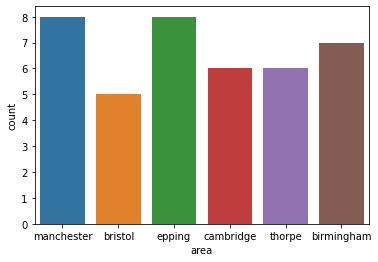

In [13]:
sns.countplot(x = traffic_predictions.area)

## Results on train vs test set

### AADT

In [6]:
def model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model):
    ''' 
    Function that applies a traffic model to the area test_report and the predictions from traffic_predictions_focus and outputs the results
    '''
    
    avg_flow_preds_sat = []
    avg_flow_preds = []
    avg_flows = []    
    # For each site in the test area estimate the average flow over date_range
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.replace(' ', '').split(',')
        
        # Obtain the true traffic flow for site_list
        test_report_site = test_report[(test_report.site_id.isin(site_list)) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean()
        
        # Obtain the count values for site_list
        X_t_values = test_report_site[test_report_site.timestamp == time].total_volume
        # Take the mean of these count values
        X_t = X_t_values.mean()
        # Make a prediction of avg_flow from the true counts
        avg_flow_pred = X_t/model.N(time) * model.mean_N(date_range)
        
        # Obtain the count values via satellite for site_list
        X_t_sat = traffic_predictions_focus[traffic_predictions_focus.sites == sites_str].all_vehicle_pred.to_numpy()
        # Make a prediction of avg_flow from the satellites counts
        avg_flow_pred_sat = X_t_sat/model.N(time) * model.mean_N(date_range)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())
        avg_flow_preds_sat.append(avg_flow_pred_sat.item())
        
        
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    return avg_flows, avg_flow_preds, avg_flow_preds_sat

In [7]:
AADT_sat_results = defaultdict(str)
AADT_sat_results_train = defaultdict(str)

areas = ["birmingham", "cambridge", "bristol"]
for area in areas:
    print(area)
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    train_report, __ = get_reports(area)
    
    model = Normalised_Flow_Model(train_report)
    test_report = image_year_reports[area]
    
    time = times[area]
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AADT_sat_results[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)
    
    
    avg_flows_train = []
    avg_flow_preds_train = []
    avg_flow_preds_sat_train = []
    # Now test the pipipeline on each of the training areas so check whether overfit is a problem
    for train_area in [train_area for train_area in areas if train_area != area]:
        traffic_predictions_focus = traffic_predictions[traffic_predictions.area == train_area]
        test_report = image_year_reports[train_area]
        time = times[train_area]
        start_str, end_str = year_str(time)
        date_range = pd.date_range(start_str, end_str, freq="15min")
        
        avg_flows_train_area, avg_flow_preds_train_area, avg_flow_preds_sat_train_area = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)
        
        avg_flows_train += avg_flows_train_area
        avg_flow_preds_train += avg_flow_preds_train_area
        avg_flow_preds_sat_train += avg_flow_preds_sat_train_area
    
    AADT_sat_results_train[area] = avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train
        

birmingham
cambridge
bristol


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  9725.02 		 MSE: 8801.16 		 MSE: 4309.27
MAE:  87.18  		 MAE: 75.48 		 MAE: 54.46
MAPE: 0.36 		 MAPE: 0.2 		 MAPE 0.14
R^2:  0.8 		 R^2: 0.82 		 R^2: 0.31


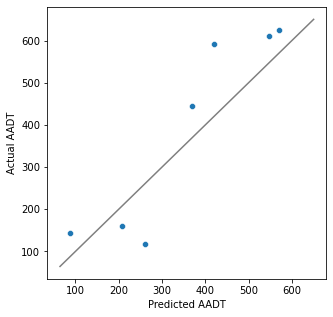

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  14337.61 		 MSE: 1578.2 		 MSE: 7397.25
MAE:  100.86  		 MAE: 31.05 		 MAE: 71.37
MAPE: 0.29 		 MAPE: 0.09 		 MAPE 0.18
R^2:  -2.73 		 R^2: 0.59 		 R^2: 0.76


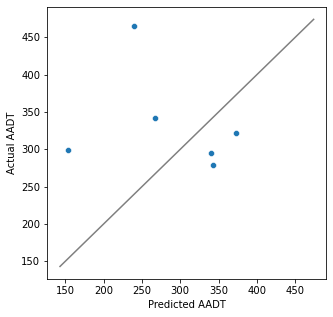

Area bristol
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  25107.23 		 MSE: 7780.99 		 MSE: 5093.68
MAE:  136.54  		 MAE: 78.24 		 MAE: 53.24
MAPE: 0.36 		 MAPE: 0.19 		 MAPE 0.14
R^2:  -4.11 		 R^2: -0.59 		 R^2: 0.82


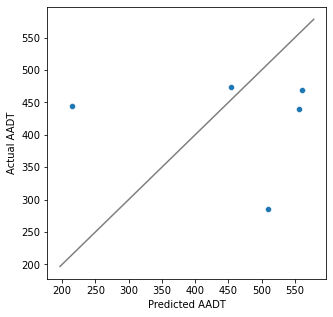

In [8]:
# Print and plot results

for location, AADT_result in AADT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AADT_sat_results_train[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    
    metrics_gold_counts_train = report_metrics(avg_flows_train, avg_flow_preds_train)
    mse_gt, mae_gt, mape_gt, r2_gt = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count Train Metrics')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gt, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gt, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gt, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gt, 2))}")
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

### AMMT

In [19]:
AAMT_sat_results = defaultdict(str)
AAMT_sat_results_train = defaultdict(str)
areas = ['birmingham', 'manchester', 'cambridge', 'thorpe', 'epping', 'bristol']
for area in areas:
    print(area)
    traffic_predictions_focus = traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    train_report, __ = get_reports(area)
    
    model = Normalised_Flow_Model(train_report)
    test_report = image_year_reports[area]
    
    time = times[area]
    start_str, end_str = month_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AAMT_sat_results[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)

    
    avg_flows_train = []
    avg_flow_preds_train = []
    avg_flow_preds_sat_train = []
    # Now test the pipipeline on each of the training areas so check whether overfit is a problem
    for train_area in [train_area for train_area in areas if train_area != area]:
        traffic_predictions_focus = traffic_predictions[traffic_predictions.area == train_area]
        test_report = image_year_reports[train_area]
        time = times[train_area]
        start_str, end_str = year_str(time)
        date_range = pd.date_range(start_str, end_str, freq="15min")
        
        avg_flows_train_area, avg_flow_preds_train_area, avg_flow_preds_sat_train_area = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)
        
        avg_flows_train += avg_flows_train_area
        avg_flow_preds_train += avg_flow_preds_train_area
        avg_flow_preds_sat_train += avg_flow_preds_sat_train_area
    
    AAMT_sat_results_train[area] = avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train

birmingham
manchester
cambridge
thorpe
epping
bristol


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  9727.22 		 MSE: 7934.41 		 MSE: 147841.67
MAE:  86.24  		 MAE: 74.85 		 MAE: 296.19
MAPE: 0.33 		 MAPE: 0.18 		 MAPE 0.44
R^2:  0.82 		 R^2: 0.85 		 R^2: -2.36


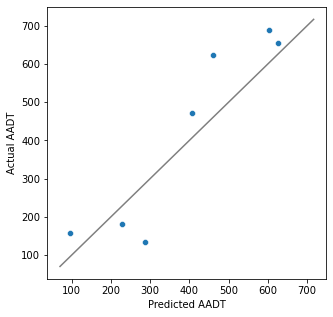

Area manchester
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  40077.94 		 MSE: 9754.85 		 MSE: 144763.58
MAE:  186.54  		 MAE: 82.75 		 MAE: 270.68
MAPE: 0.32 		 MAPE: 0.15 		 MAPE 0.4
R^2:  -0.75 		 R^2: 0.57 		 R^2: -1.57


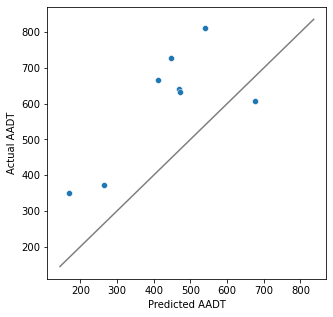

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  14516.04 		 MSE: 1192.59 		 MSE: 145710.63
MAE:  103.99  		 MAE: 31.07 		 MAE: 297.73
MAPE: 0.27 		 MAPE: 0.09 		 MAPE 0.45
R^2:  -4.71 		 R^2: 0.53 		 R^2: -1.98


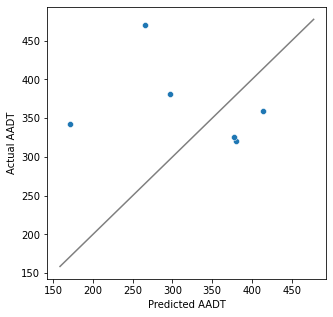

Area thorpe
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  1957.41 		 MSE: 1764.37 		 MSE: 72321.19
MAE:  32.91  		 MAE: 36.32 		 MAE: 192.57
MAPE: 0.04 		 MAPE: 0.05 		 MAPE 0.34
R^2:  0.92 		 R^2: 0.93 		 R^2: -1.03


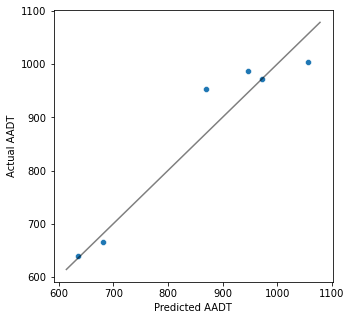

Area epping
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  32869.74 		 MSE: 1796.33 		 MSE: 92886.45
MAE:  140.68  		 MAE: 34.72 		 MAE: 199.52
MAPE: 0.2 		 MAPE: 0.05 		 MAPE 0.3
R^2:  -1.68 		 R^2: 0.85 		 R^2: -0.6


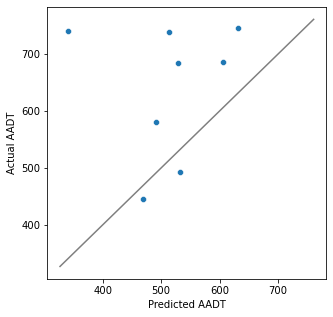

Area bristol
Satellite Metrics 	 Gold count metrics 	 Gold count Train Metrics
MSE:  37995.45 		 MSE: 4503.58 		 MSE: 141037.81
MAE:  152.6  		 MAE: 55.34 		 MAE: 284.62
MAPE: 0.3 		 MAPE: 0.1 		 MAPE 0.42
R^2:  -3.73 		 R^2: 0.44 		 R^2: -1.59


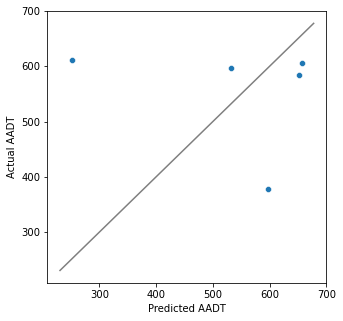

In [20]:
# Print and plot results

for location, AAMT_result in AAMT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AAMT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AAMT_sat_results_train[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_train, avg_flow_preds_train)
    mse_gt, mae_gt, mape_gt, r2_gt = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count Train Metrics')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gt, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gt, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gt, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gt, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

## Local Model vs Global Model

### AADT

In [22]:
AADT_sat_results = defaultdict(str)
AADT_sat_results_local = defaultdict(str)

areas = ["birmingham", "cambridge", "bristol"]
for area in areas:
    print(area)
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    train_report, __ = get_reports(area)
    
    model = Normalised_Flow_Model(train_report)
    test_report = image_year_reports[area]
    
    time = times[area]
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AADT_sat_results[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)
    
    __, train_report_local = get_reports(area)
    local_model = Normalised_Flow_Model(train_report_local)
    AADT_sat_results_local[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, local_model)

birmingham
cambridge
bristol


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  9725.02 		 MSE: 8801.16 		 MSE: 2945.14
MAE:  87.18  		 MAE: 75.48 		 MAE: 46.82
MAPE: 0.36 		 MAPE: 0.2 		 MAPE 0.17
R^2:  0.8 		 R^2: 0.82 		 R^2: 0.94


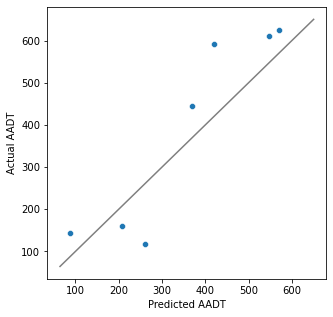

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  14337.61 		 MSE: 1578.2 		 MSE: 631.97
MAE:  100.86  		 MAE: 31.05 		 MAE: 17.75
MAPE: 0.29 		 MAPE: 0.09 		 MAPE 0.05
R^2:  -2.73 		 R^2: 0.59 		 R^2: 0.84


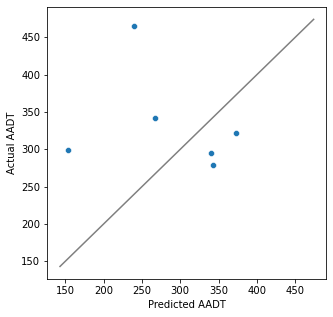

Area bristol
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  25107.23 		 MSE: 7780.99 		 MSE: 5300.22
MAE:  136.54  		 MAE: 78.24 		 MAE: 56.19
MAPE: 0.36 		 MAPE: 0.19 		 MAPE 0.12
R^2:  -4.11 		 R^2: -0.59 		 R^2: -0.08


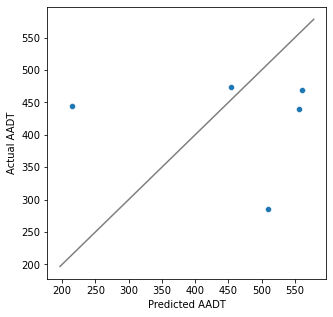

In [23]:
# Print and plot results

for location, AADT_result in AADT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result
    avg_flows_local, avg_flow_preds_local, avg_flow_preds_sat_local = AADT_sat_results_local[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_local, avg_flow_preds_local)
    mse_gl, mae_gl, mape_gl, r2_gl = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count local-train Metrics')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gl, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gl, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gl, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gl, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

### ADMT

In [15]:
AAMT_sat_results = defaultdict(str)
AAMT_sat_results_local = defaultdict(str)
for area in ['birmingham', 'manchester', 'cambridge', 'thorpe', 'epping', 'bristol']:
    print(area)
    traffic_predictions_focus = traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    train_report, __ = get_reports(area)
    
    model = Normalised_Flow_Model(train_report)
    test_report = image_year_reports[area]
    time = times[area]
    start_str, end_str = month_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    # metrics_gold_counts, metrics_satellite_counts, model, coverage, avg_flows, avg_flow_preds
    AAMT_sat_results[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)
    
    __, train_report_local = get_reports(area)
    local_model = Normalised_Flow_Model(train_report_local)
    AAMT_sat_results_local[area] = model_window_satellite(test_report, time, date_range, traffic_predictions_focus, local_model)

birmingham
manchester
cambridge
thorpe
epping
bristol


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  9727.22 		 MSE: 7934.41 		 MSE: 2212.93
MAE:  86.24  		 MAE: 74.85 		 MAE: 38.84
MAPE: 0.33 		 MAPE: 0.18 		 MAPE 0.15
R^2:  0.82 		 R^2: 0.85 		 R^2: 0.96


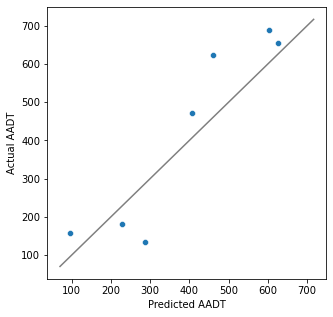

Area manchester
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  40077.94 		 MSE: 9754.85 		 MSE: 6996.39
MAE:  186.54  		 MAE: 82.75 		 MAE: 67.88
MAPE: 0.32 		 MAPE: 0.15 		 MAPE 0.12
R^2:  -0.75 		 R^2: 0.57 		 R^2: 0.69


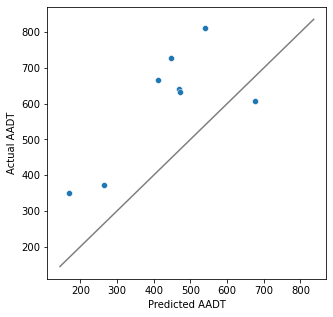

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  14516.04 		 MSE: 1192.59 		 MSE: 292.31
MAE:  103.99  		 MAE: 31.07 		 MAE: 13.1
MAPE: 0.27 		 MAPE: 0.09 		 MAPE 0.04
R^2:  -4.71 		 R^2: 0.53 		 R^2: 0.89


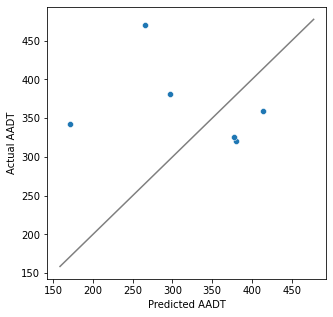

Area thorpe
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  1957.41 		 MSE: 1764.37 		 MSE: 725.65
MAE:  32.91  		 MAE: 36.32 		 MAE: 19.64
MAPE: 0.04 		 MAPE: 0.05 		 MAPE 0.03
R^2:  0.92 		 R^2: 0.93 		 R^2: 0.97


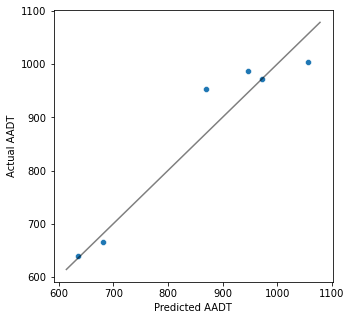

Area epping
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  32869.74 		 MSE: 1796.33 		 MSE: 1233.6
MAE:  140.68  		 MAE: 34.72 		 MAE: 31.85
MAPE: 0.2 		 MAPE: 0.05 		 MAPE 0.05
R^2:  -1.68 		 R^2: 0.85 		 R^2: 0.9


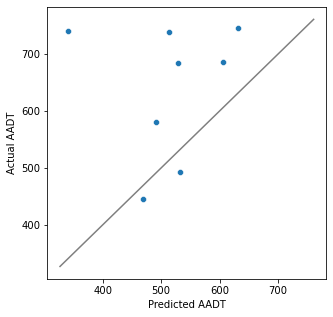

Area bristol
Satellite Metrics 	 Gold count metrics 	 Gold count local-train Metrics
MSE:  37995.45 		 MSE: 4503.58 		 MSE: 6431.93
MAE:  152.6  		 MAE: 55.34 		 MAE: 60.65
MAPE: 0.3 		 MAPE: 0.1 		 MAPE 0.1
R^2:  -3.73 		 R^2: 0.44 		 R^2: 0.2


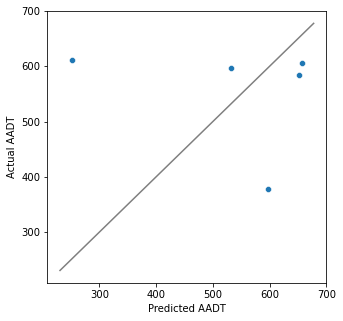

In [16]:
# Print and plot results

for location, AAMT_result in AAMT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AAMT_result
    avg_flows_local, avg_flow_preds_local, avg_flow_preds_sat_local = AAMT_sat_results_local[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_local, avg_flow_preds_local)
    mse_gl, mae_gl, mape_gl, r2_gl = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count local-train Metrics')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gl, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gl, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gl, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gl, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AAMT')